<h1> Training <code>shot angle</code> </h1>

**Labels:**
* aerial
* eye-level
* high
* low

We only want to do transfer learning i.e. create a new head and train that alone, because we need the body to remain the same across different categories aka. MobileNetV2 pretrained on ImageNet

In [1]:
# Dynamically load package
%load_ext autoreload
%autoreload 2

# Display multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from CinemaNet.convert import *
from fastai.vision import *
from fastai.callbacks import *
from ranger import Ranger
from CinemaNet.blend import *
from CinemaNet.wandb import *
from CinemaNet.custom_head import *
from CinemaNet.train_utils import to_film_ar # other utils will be redefined for clarity

import wandb

In [3]:
model_name = 'cat_shot-angle_MNetV2-224x224_tfr-lrn'

In [5]:
wandb.init(name    = f"{re.sub('cat_[a-z].*_MN', 'MN', model_name)}",
           project = 'shot_angle',
           entity  = 'synopsis',
           reinit  = True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/synopsis/shot_angle/runs/2pvcmfpu

In [6]:
%env WANDB_NOTEBOOK_NAME='cat_color-theory.ipynb'

env: WANDB_NOTEBOOK_NAME='cat_color-theory.ipynb'


## Creating Train + Val Datasets

In [7]:
path = Path('/home/rahul/datasets/Synopsis_Model_All_Concepts/shot_angle/')

### Shot Angle Data

In [9]:
label_dirs = [f for f in os.listdir(path) if f.startswith('shot_angle_')]
label_dirs.sort()
label_dirs

['shot_angle_aerial',
 'shot_angle_eyelevel',
 'shot_angle_high',
 'shot_angle_low']

In [21]:
for f in label_dirs:
    print(f"{f} --> {len((path/f).ls())}")

shot_angle_aerial --> 484
shot_angle_eyelevel --> 235
shot_angle_high --> 224
shot_angle_low --> 248


In [22]:
train_fnames = {}
valid_fnames = {}

for label in label_dirs:
    files    = get_files(path/label, presort=True)
    np.random.seed(42)
    np.random.shuffle(files)
    if len(files) < 250:
        valid_fnames[label] = files[:50]
        train_fnames[label] = files[50:]
    else:
        valid_fnames[label] = files[:100]
        train_fnames[label] = files[100:]

In [34]:
fnames_train = sum(train_fnames.values(),[])
fnames_valid = sum(valid_fnames.values(),[])

print(f"# train images: {len(fnames_train)}")
print(f"# valid images: {len(fnames_valid)}")
print(f"# total images: {len(fnames_train) + len(fnames_valid)}")

# train images: 937
# valid images: 250
# total images: 1187


### `NA` Data (Texture)

In [35]:
textures_dir = Path('/home/rahul/datasets/Synopsis_Model_All_Concepts/texture/')
textures     = get_files(textures_dir, recurse=True)
print(f"# texture images: {len(textures)}")

# texture images: 5518


In [36]:
textures_subdirs = [f for f in os.listdir(textures_dir) if f.startswith('texture_')]

texture_train_fnames = {}
texture_valid_fnames = {}

for label in textures_subdirs:
    files    = get_files(textures_dir/label, presort=True)
    np.random.seed(42)
    np.random.shuffle(files)
#     if len(files) <= 120:
#         texture_valid_fnames[label] = files[:25]
#         texture_train_fnames[label] = files[25:75]
#     else:
#         texture_valid_fnames[label] = files[:25]
#         texture_train_fnames[label] = files[25:75]

    # grab 30 train, 10 valid images from each label
    texture_valid_fnames[label] = files[:10]
    texture_train_fnames[label] = files[10:40]

In [37]:
fnames_textures_train = sum(texture_train_fnames.values(),[])
fnames_textures_valid = sum(texture_valid_fnames.values(),[])

print(f"# texture train images: {len(fnames_textures_train)}")
print(f"# texture valid images: {len(fnames_textures_valid)}")

# texture train images: 1350
# texture valid images: 450


In [38]:
fnames_valid = fnames_valid + fnames_textures_valid
fnames_train = fnames_train + fnames_textures_train

print(f"# train images: {len(fnames_train)}")
print(f"# valid images: {len(fnames_valid)}")
print(f"# total images: {len(fnames_train) + len(fnames_valid)}")

# train images: 2287
# valid images: 700
# total images: 2987


### Collate Into DataFrame

In [68]:
def get_data_df(fnames, regex) -> pd.DataFrame:
    row_list = []
    for i,f in enumerate(fnames):
        rowdict = {}
        rowdict['filepath'] = str(f)
        label = re.search(regex, str(f))
        if label:
            label = label.group(0).split('/')[:-1][0] # remove '/'; get str, not list
            rowdict['label'] = label
        else:
            rowdict['label'] = 'NA'
        #rowdict['filepath'] = re.search('(?<=shot_location/).*', str(f)).group(0)
        row_list.append(rowdict)

    return pd.DataFrame(row_list)

In [69]:
datagrab = partial(get_data_df, regex='(?<=shot_angle/shot_angle_).*/')
df_train = datagrab(fnames_train)
df_valid = datagrab(fnames_valid)

In [70]:
lls = LabelLists(path  = '/',
                 train = ImageList.from_df(df_train, path='/'),
                 valid = ImageList.from_df(df_valid, path='/'))

In [71]:
img_size   = (224,224)
batch_size = 64

In [72]:
tfms = get_transforms()
tfms = tfms[0], []      # remove cropping tfm from validation-transforms

In [73]:
data = (lls
        .label_from_df()
        .transform(tfms=get_transforms(),
                   size=img_size,
                   resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (2287 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
aerial,aerial,aerial,aerial,aerial
Path: /;

Valid: LabelList (700 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
aerial,aerial,aerial,aerial,aerial
Path: /;

Test: None

In [76]:
data.classes

['NA', 'aerial', 'eyelevel', 'high', 'low']

In [77]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes
pd.DataFrame(vc)

0
NA        1350
aerial     184
eyelevel   197
high       383
low        173

In [78]:
vc = pd.value_counts(data.valid_ds.y.items, sort=False)
vc.index = data.classes
pd.DataFrame(vc)

0
NA        450
aerial    100
eyelevel   50
high       50
low        50

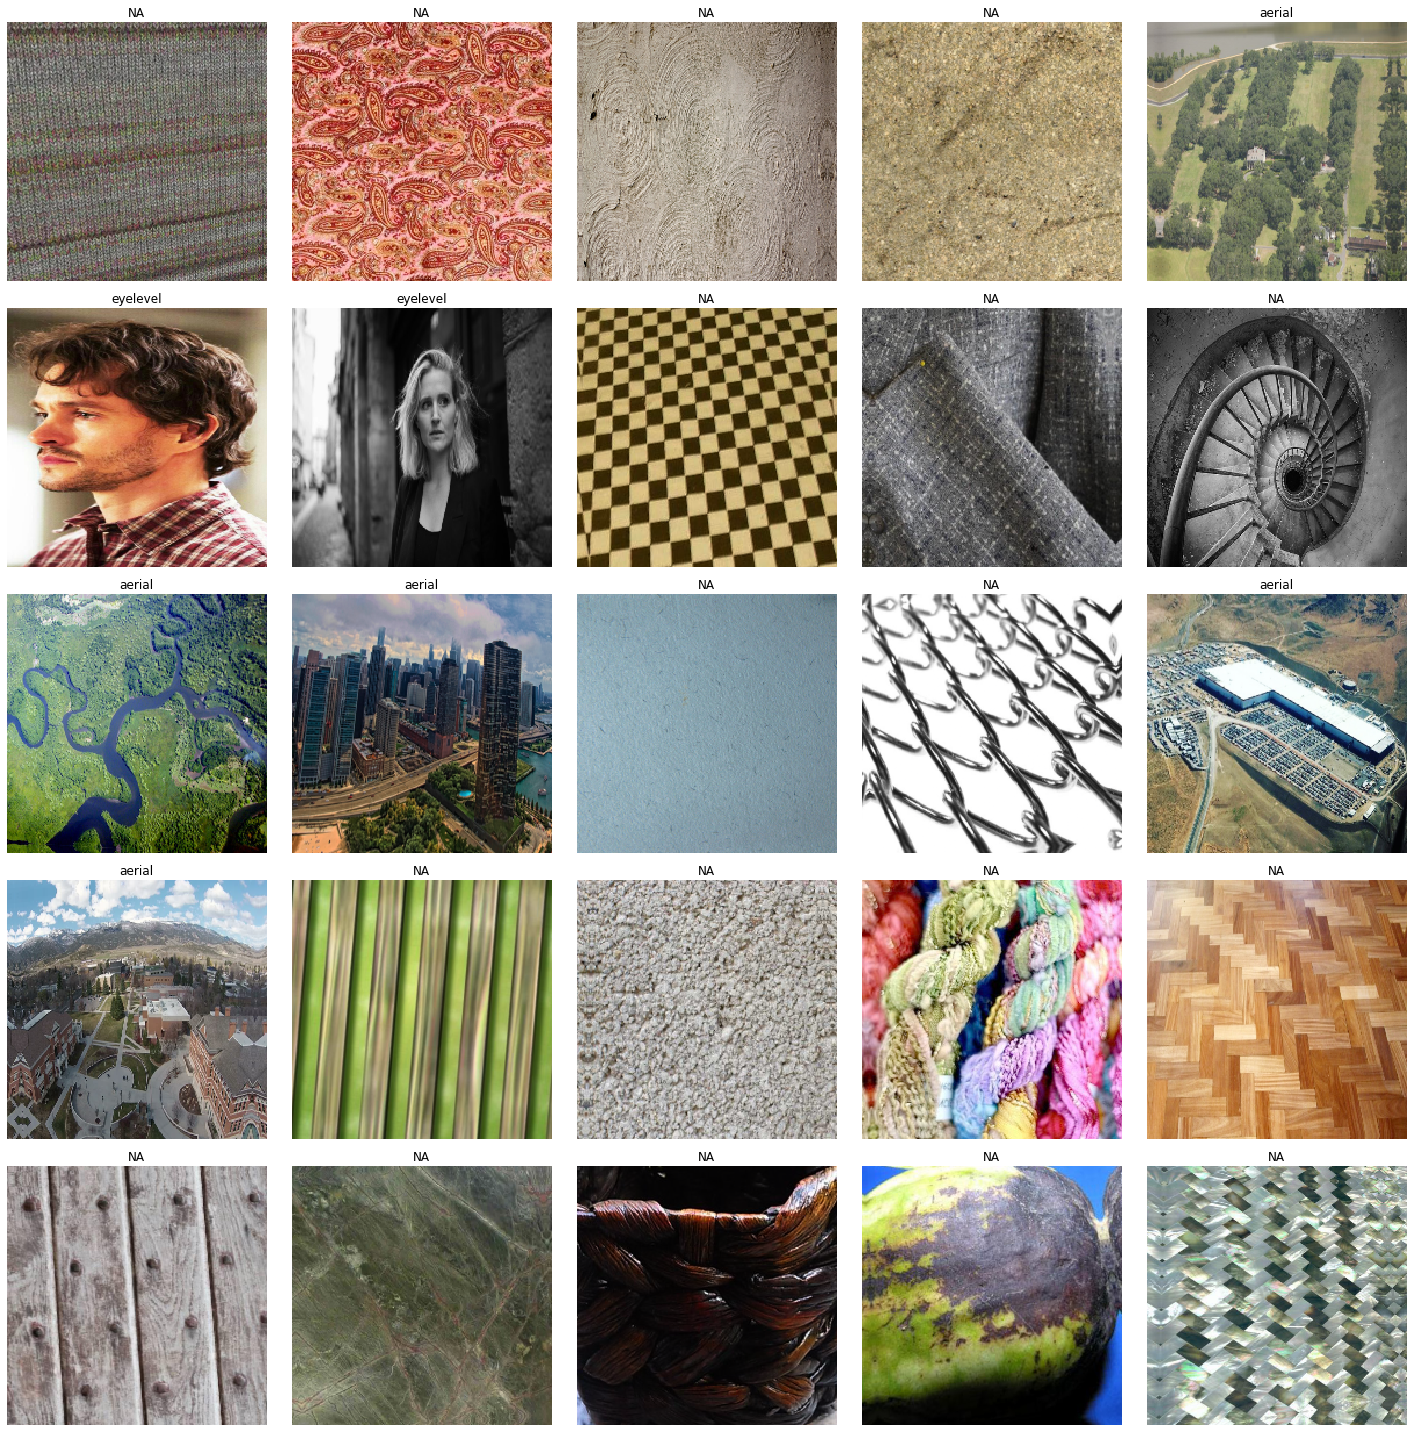

In [79]:
data.show_batch()

## Model Setup

### Architecture, Loss Function, Optimiser

In [80]:
arch = models.mobilenet_v2
loss_func = LabelSmoothingCrossEntropy()
opt_func  = Ranger

In [81]:
model_name

'cat_shot-angle_MNetV2-224x224_tfr-lrn'

In [82]:
metrics = [accuracy, FBeta()]

def get_callbacks(learner, mod_name, monitor='f_beta'):
    return [
        SaveModelCallback(learner, name=mod_name, monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images',
                          log='all', predictions=100)
    ]

### Data Augmentations

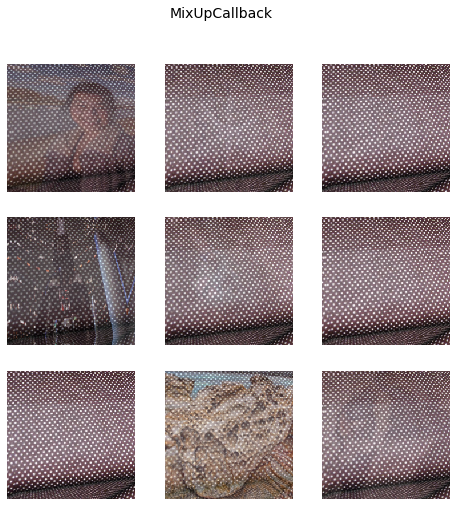

In [85]:
tmp = Learner(data,arch()).mixup().show_tfms()

### Model

In [86]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics,opt_func=opt_func, 
                    loss_func=loss_func)
learn = learn.mixup()

## Training

### Flat cosine annealing w/ Ranger (Lookahead + RAdam) Optimiser

In [88]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics,opt_func=opt_func, 
                    loss_func=loss_func)
learn = learn.mixup()

In [89]:
model_name

'cat_shot-angle_MNetV2-224x224_tfr-lrn'

In [94]:
learn.path = path

In [95]:
learn.save(model_name) # avoid potential `SaveModelCallback` bugs

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-01
Min loss divided by 10: 7.59E-02


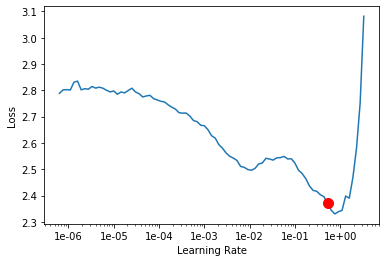

In [96]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [97]:
model_name = f'{model_name}-opt_ranger-cos_anneal'
callbacks = get_callbacks(learn, model_name)

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with f_beta value: 0.44375285506248474.
Better model found at epoch 0 with f_beta value: 0.44375285506248474.
Better model found at epoch 1 with f_beta value: 0.47435981035232544.
Better model found at epoch 1 with f_beta value: 0.47435981035232544.
Better model found at epoch 2 with f_beta value: 0.5360295176506042.
Better model found at epoch 2 with f_beta value: 0.5360295176506042.
Better model found at epoch 4 with f_beta value: 0.6551640629768372.
Better model found at epoch 4 with f_beta value: 0.6551640629768372.
set state called
set state called
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_180506-2pvcmfpu/bestmodel.pth


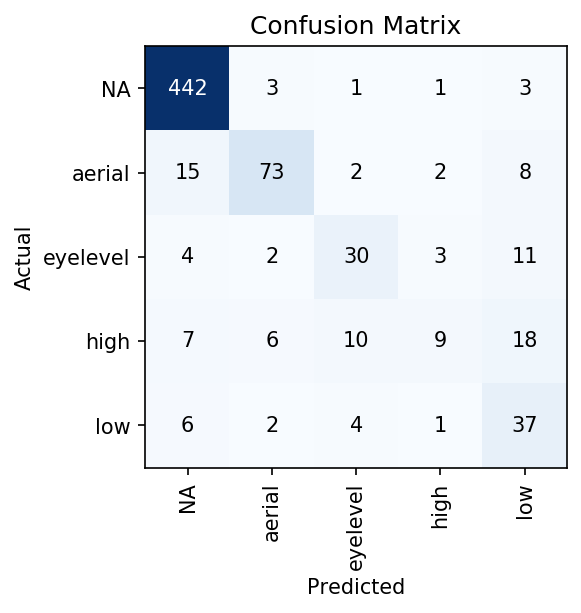

In [98]:
learn.fit_fc(5, 2e-1, wd=1e-2, callbacks=callbacks)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 1.58E-07


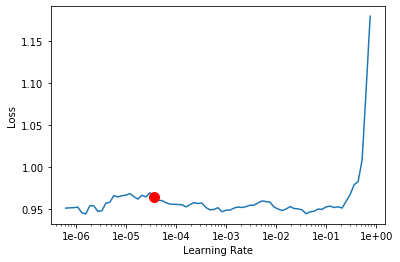

In [99]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with f_beta value: 0.6363345384597778.
Better model found at epoch 0 with f_beta value: 0.6363345384597778.


wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with f_beta value: 0.6560341119766235.
Better model found at epoch 1 with f_beta value: 0.6560341119766235.
Better model found at epoch 2 with f_beta value: 0.6622635722160339.
Better model found at epoch 2 with f_beta value: 0.6622635722160339.
set state called
set state called
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_180506-2pvcmfpu/bestmodel.pth


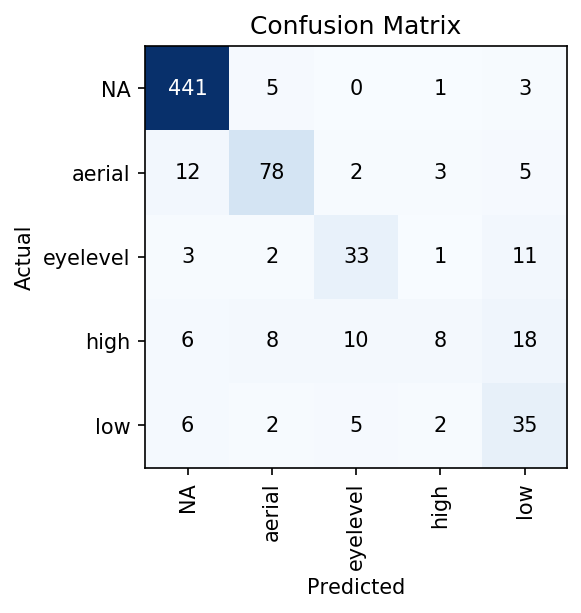

In [101]:
learn.fit_fc(5, 1e-3, callbacks=callbacks)

## Interpretation

In [102]:
(learn.path/'models').ls()

[PosixPath('/home/rahul/datasets/Synopsis_Model_All_Concepts/shot_angle/models/cat_shot-angle_MNetV2-224x224_tfr-lrn.pth'),
 PosixPath('/home/rahul/datasets/Synopsis_Model_All_Concepts/shot_angle/models/tmp.pth'),
 PosixPath('/home/rahul/datasets/Synopsis_Model_All_Concepts/shot_angle/models/cat_shot-angle_MNetV2-224x224_tfr-lrn-opt_ranger-cos_anneal.pth')]

In [107]:
learn.load(model_name);

set state called


In [108]:
interpret = learn.interpret()

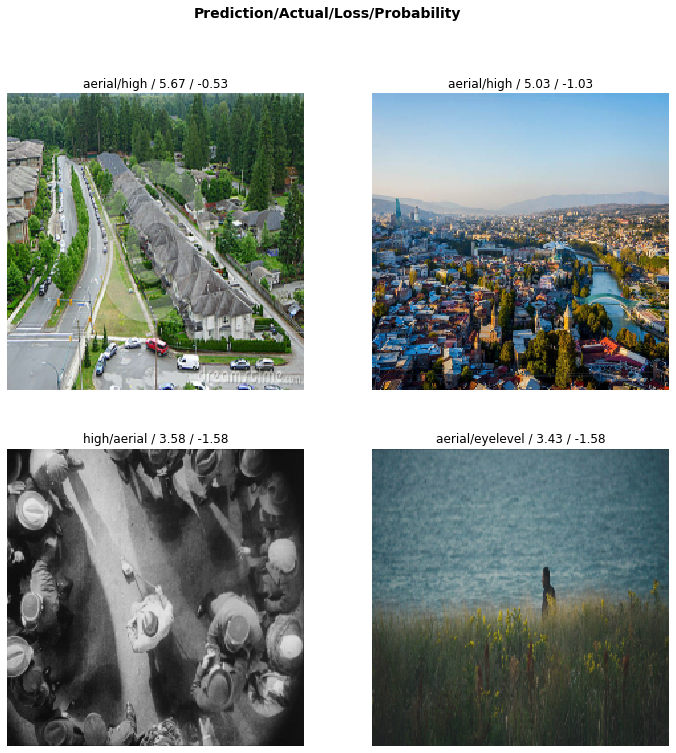

In [110]:
interpret.plot_top_losses(4)

In [111]:
interpret.most_confused()

[('high', 'low', 18),
 ('aerial', 'NA', 12),
 ('eyelevel', 'low', 11),
 ('high', 'eyelevel', 10),
 ('high', 'aerial', 8),
 ('high', 'NA', 6),
 ('low', 'NA', 6),
 ('NA', 'aerial', 5),
 ('aerial', 'low', 5),
 ('low', 'eyelevel', 5),
 ('NA', 'low', 3),
 ('aerial', 'high', 3),
 ('eyelevel', 'NA', 3),
 ('aerial', 'eyelevel', 2),
 ('eyelevel', 'aerial', 2),
 ('low', 'aerial', 2),
 ('low', 'high', 2),
 ('NA', 'high', 1),
 ('eyelevel', 'high', 1)]

It's clear that the labels that need more labelling are  `color_saturation_saturated` and `color_saturation_pastel`

## Rename Files & Save to Weights & Biases

In [112]:
learn.load(model_name); # this is just a sanity check, out callbacks would have loaded the best model anyways

set state called


In [113]:
torch_to_coreml(learn.model, data.c, model_fname=f'{model_name}-FULL')

Converted PyTorch to ONNX
Converting ONNX to CoreML

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Conver

In [114]:
!ls -l ../exported-models/{model_name}*

-rw-rw-r-- 1 rahul rahul 14344797 Feb 11 00:03 ../exported-models/cat_shot-angle_MNetV2-224x224_tfr-lrn-opt_ranger-cos_anneal-FULL.mlmodel
-rw-rw-r-- 1 rahul rahul 14355265 Feb 11 00:03 ../exported-models/cat_shot-angle_MNetV2-224x224_tfr-lrn-opt_ranger-cos_anneal-FULL.onnx


In [115]:
wandb.save(f'../exported-models/{model_name}*')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_180506-2pvcmfpu/cat_shot-angle_MNetV2-224x224_tfr-lrn-opt_ranger-cos_anneal-FULL.onnx',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_180506-2pvcmfpu/cat_shot-angle_MNetV2-224x224_tfr-lrn-opt_ranger-cos_anneal-FULL.mlmodel']

In [116]:
!ls {learn.path}/{model_name}*csv

/home/rahul/datasets/Synopsis_Model_All_Concepts/shot_angle/cat_shot-angle_MNetV2-224x224_tfr-lrn-opt_ranger-cos_anneal-history.csv


In [117]:
wandb.save(f'{learn.path}/{model_name}*csv')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_180506-2pvcmfpu/cat_shot-angle_MNetV2-224x224_tfr-lrn-opt_ranger-cos_anneal-history.csv']